# Импортируем библиотеки

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import os
import sys
import random
import copy
import time
import shutil
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from pandas import DataFrame
import seaborn as sns
import pandas as pd
import numpy as np
import PIL
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn import preprocessing
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix





def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(42)

# Загружаем датасет

In [2]:
!mkdir steel_surface_defects

In [ ]:
!unzip /content/steel_surface_defects_4.zip -d /content/steel_surface_defects

In [4]:
import os

root = '/content/steel_surface_defects'

all_img_list = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if name.endswith('.jpg'):
          all_img_list.append(os.path.join(path, name))

Рассчитаем среднее значение и стандартное отклонение для изображений из нашей выборки:

In [5]:
from PIL import Image
rgb_values = np.concatenate(
    [Image.open(img).getdata() for img in all_img_list],
    axis=0
) / 255.

# rgb_values.shape == (n, 3),
# where n is the total number of pixels in all images,
# and 3 are the 3 channels: R, G, B.

# Each value is in the interval [0; 1]

mean_rgb = torch.tensor(np.mean(rgb_values, axis=0))  # mu_rgb.shape == (3,)
std_rgb = torch.tensor(np.std(rgb_values, axis=0))  # std_rgb.shape == (3,)

print(mean_rgb, std_rgb)

tensor([0.3512, 0.3512, 0.3512], dtype=torch.float64) tensor([0.0389, 0.0389, 0.0389], dtype=torch.float64)


# Создаём датасет

In [34]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.Grayscale(num_output_channels=3), #переводим из Grayscale в RGB, чтобы использовать предобученную модель
        transforms.ToTensor(),
        transforms.Normalize(mean_rgb, std_rgb)
    ]),
    'valid': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.Grayscale(num_output_channels=3), #переводим из Grayscale в RGB, чтобы использовать предобученную модель
        transforms.ToTensor(),
        transforms.Normalize(mean_rgb, std_rgb)
    ]),
    'test': transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(num_output_channels=3), #переводим из Grayscale в RGB, чтобы использовать предобученную модель
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb)])
    }

data_dir = '/content/steel_surface_defects'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

На основе имеющихся данных удалось выделить 4 типа дефектных структур. Подробнее о них будет сказано в следующем разделе.

In [ ]:
class_names

['dent', 'dots', 'hole', 'noisy']

In [ ]:
print(dataset_sizes)

{'train': 229, 'valid': 69, 'test': 33}


# Визуализация данных

torch.Size([3, 256, 256])
Label: dent


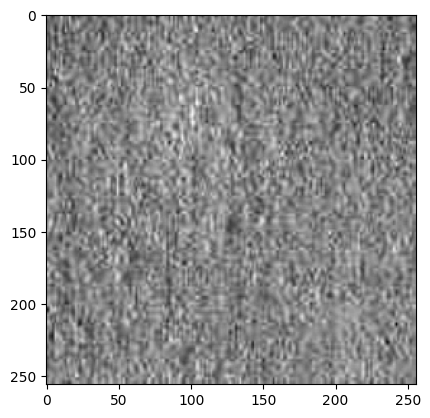

In [ ]:
img_1, label_1 = image_datasets['valid'][13]
print(img_1.shape)
plt.imshow(img_1[2,:,:], cmap='gray')
print('Label:', class_names[label_1])


In [ ]:
#генерируем список из 10 рандомных чисел в отрезке от нуля до размера тренировочного датасета

random_numb = random.sample(range(0, dataset_sizes['train']), 10)
print(random_numb)

[173, 189, 228, 139, 22, 151, 108, 8, 7, 23]


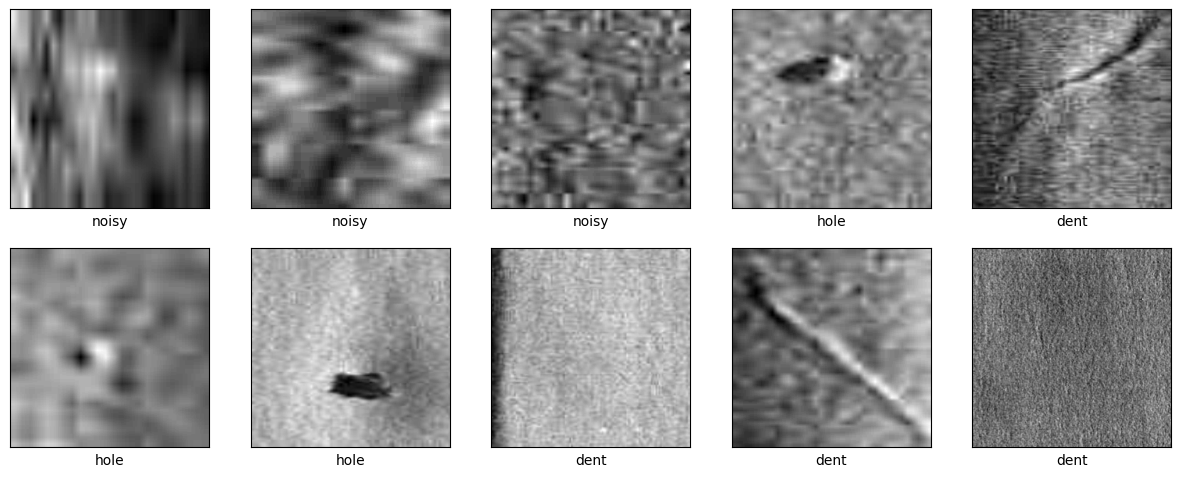

In [ ]:
# Посмотрим на 10 случайных изображений из тренировочного датасета
plt.figure(figsize=(15,15))
for i,j in enumerate(random_numb):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img, label = image_datasets['train'][j]
    plt.imshow(img[2,:,:], cmap='gray')

    if label == 0:
      plt.xlabel("dent")
    elif label == 1:
      plt.xlabel("dots")
    elif label == 2:
      plt.xlabel('hole')
    elif label == 3:
      plt.xlabel('noisy')
    #plt.xlabel(class_names[train_labels[i][0]])
plt.show()

**Описание дефектных структур:**


1.   `Hole` - дырка(включение). представляет собой один или несколько тёмных кругов или фигур произвольной формы на светлой поверхности.
2.   `Noisy` - зашумлённые фрагменты с  поверхности стали. на таких изображениях как правило отсутствуют чёткие области/края.
3.   `Dent` -  как правило, довольно чёткие изображения с поверхности стали, содержищие шероховатости или вмятины.
4.   `Dots` - тёмные точки небольшого размера, расположенные в группе. часто группируются в форме звезды. этих дефектов было не так много в архиве, поэтому специально сгенерил синтетику для этого класса дефекта.



## Распределение количества изображений по классам для каждой из выборок

<ipython-input-116-9f5fbf5a8684>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')  # Adjust colormap as needed


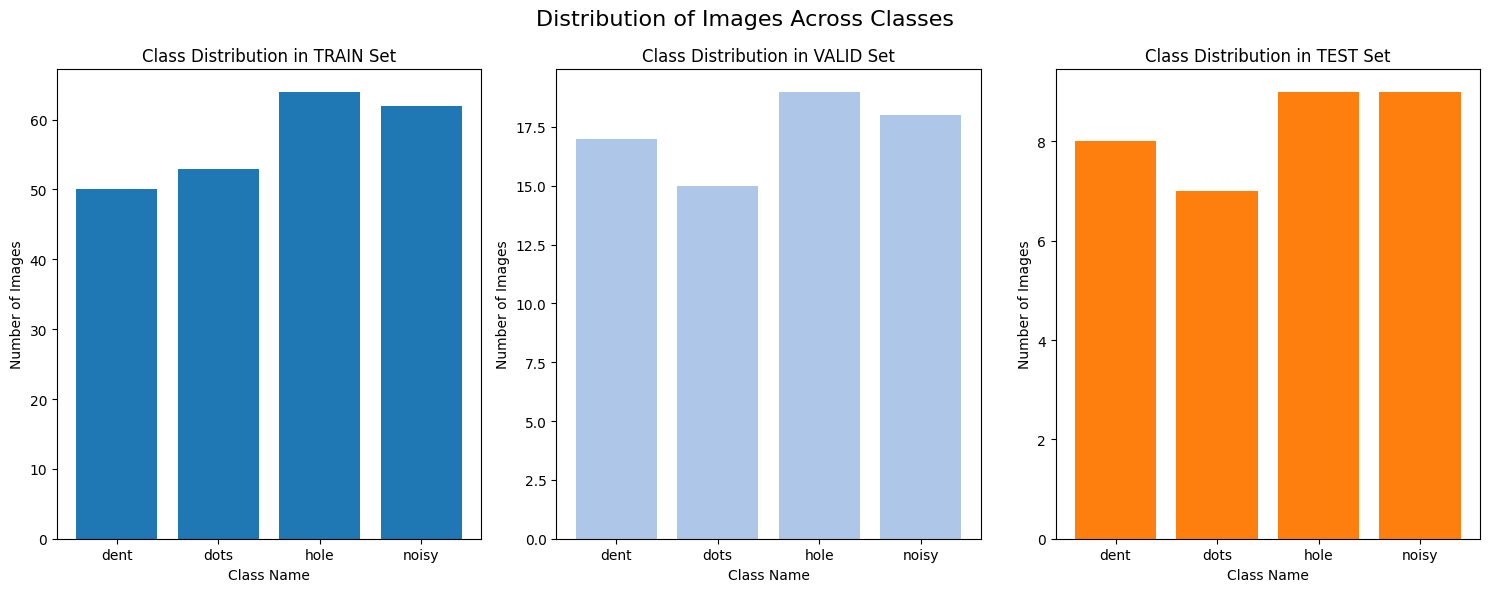

In [ ]:
def plot_class_distribution(dataloaders, dataset_sizes, class_names):
  """
  Plots the distribution of images among classes for train, validation, and test sets.

  Args:
      dataloaders (dict): A dictionary containing dataloaders for train, validation, and test sets.
      dataset_sizes (dict): A dictionary containing the size of each dataset (train, validation, test).
      class_names (list): A list of class names corresponding to the classes in the dataset.
  """

  # Create a colormap for class bars (using color cycling)
  cmap = plt.cm.get_cmap('tab20')  # Adjust colormap as needed

  # Create subplots for train, validation, test
  fig, axes = plt.subplots(1, 3, figsize=(15, 6))

  # Loop through each split (train, validation, test)
  for i, (split, dataloader) in enumerate(dataloaders.items()):
    class_counts = {name: 0 for name in class_names}

    # Update class counts for the current split
    for _, labels in dataloader:
      for label in labels:
        class_counts[class_names[label.item()]] += 1

    # Create bar plot for the current split
    axes[i].bar(class_names, class_counts.values(), color=cmap(i))
    axes[i].set_xlabel("Class Name")
    axes[i].set_ylabel("Number of Images")
    axes[i].set_title(f"Class Distribution in {split.upper()} Set")
    #axes[i].set_xticks(rotation=45, ha="right")

  # Adjust layout and display the plots
  fig.suptitle("Distribution of Images Across Classes", fontsize=16)
  plt.tight_layout()
  plt.show()

# Call the function to plot the distribution
plot_class_distribution(dataloaders, dataset_sizes, class_names)

Как видим, в тренировочной валидационной и тестовой выборках не наблюдается дисбаланс классов

# Обучение

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0 #; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = []
    hist_loss_val = []; hist_acc_val = []

    for epoch in range(num_epochs):    # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:    # Iterate over data.
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                #with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':     # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                hist_loss_train.append(epoch_loss)
                hist_acc_train.append(epoch_acc.cpu().item())
            else:
                hist_loss_val.append(epoch_loss)
                hist_acc_val.append(epoch_acc.cpu().item())
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc.item()
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        clear_output(True)



        plt.plot(hist_loss_train,label='hist_loss_train ({})'.format(round(hist_loss_train[-1],2)))
        plt.plot(hist_loss_val,label='hist_loss_val ({})'.format(round(hist_loss_val[-1],2)))
        plt.legend(framealpha=1, frameon=True);
        plt.title('Loss (epoch {}/{})'.format(epoch,num_epochs))
        plt.grid(linestyle='dashed')
        plt.show()

        plt.plot(hist_acc_train,label='hist_acc_train')
        plt.plot(hist_acc_val,label='hist_acc_val')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Acc')
        plt.grid(linestyle='dashed')
        plt.show()
    model.eval()

    model.load_state_dict(best_model_wts)     # load best model weights

    print(f"Best validation accuracy:{round(best_acc,3)}")
    print(f"Best validation loss:{round(best_loss,2)}")
    print(f"Best validation epoch:{round(best_epoch)}")


    return model,best_acc

In [8]:
def predict(model, test_loader):
    model.eval()
    logits=[]
    tr_lab = []

    runninig_correct = 0
    for data in dataloaders['valid']:
        # получаем картинки и метки
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        logits.append(list(predicted.cpu().numpy()))
        tr_lab.append(list(labels.cpu().numpy()))
    return logits, tr_lab


In [9]:
def visualize_model(model, num_images = 6, dataloader='valid'):
  images_so_far = 0
  fig = plt.figure(figsize=(14,10))

  model.eval()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[dataloader]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      pred_probs = torch.softmax(outputs.data, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        plt.subplot(2,3,images_so_far)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(inputs.cpu().data[j][2,:,:], cmap='gray') ## or we can write: plt.imshow(inputs.data[j].permute(1,2,0), cmap='gray')
        plt.xlabel(f"Predicted label:{class_names[preds[j]]}\n Probability:{pred_probs[j].max():.2f} \n True label:{class_names[labels[j]]} ", fontsize=12)

        if images_so_far == num_images:
          return


Решил использовать `AlexNet` для обучения.

**Мотивы:**

1.   По собственному опыту лучше работает для промышленных изображений в оттенках серого, не содержащих что-то супер сложное
2.   Попробовал также `Vgg16` на этом наборе данных, но он показал себя хуже, чем `AlexNet`.




In [10]:
model_alexnet = models.alexnet(pretrained = True)

model_alexnet.classifier = nn.Linear(9216, 4)

model_alexnet = model_alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_alexnet = optim.SGD(model_alexnet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_alexnet, step_size=7, gamma=0.1)
print(model_alexnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 155MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=4, bias=True)
)


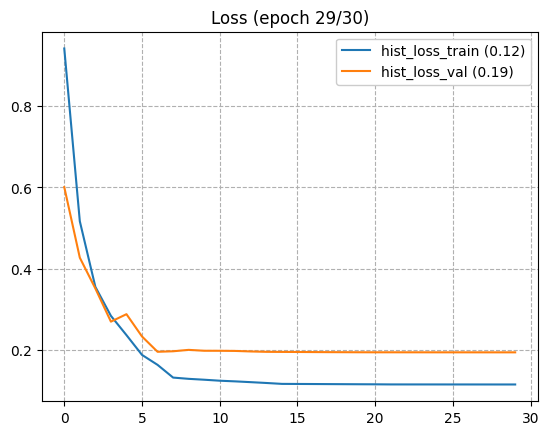

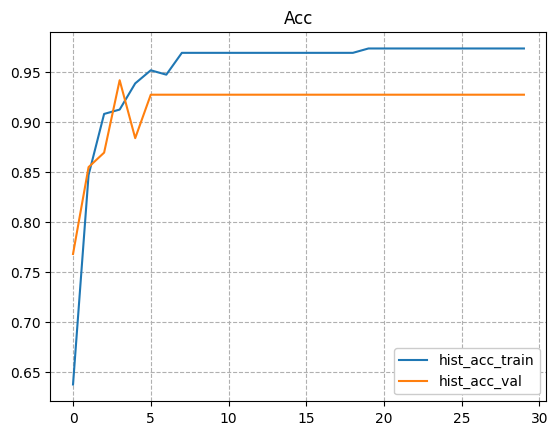

Best validation accuracy:0.942
Best validation loss:0.27
Best validation epoch:3


In [11]:
model_alexnet,best_acc = train_model(model_alexnet, criterion, optimizer_alexnet, exp_lr_scheduler, 30)


In [12]:
torch.save(model_alexnet.state_dict(), 'alexnet.pth')

# Оценка результатов

Ниже функция для подсчёта метрик - `precision`, `recall`, `f1-мера`, `accuracy`, а также `матрица ошибок`. Метрики можно подсчитать как для валидационной, так и для тестовой выборок.

In [13]:
from sklearn.metrics import classification_report


def metrics_calculation(model, dataloader):

  print(f'Metrics for {dataloader} set')
  true_labels=[]
  pred_labels=[]
  for inputs, labels in dataloaders[dataloader]:
    pred = model(inputs.to(device))
    _, pred = torch.max(pred, 1)
    labels.to(torch.device("cpu"))
    pred.to(torch.device("cpu"))
    true_labels.extend(labels.tolist());
    pred_labels.extend(pred.tolist());
  cm=metrics.confusion_matrix(true_labels,pred_labels)
  #print(cm)
  fig, ax = plt.subplots(figsize=(6,6))
  df_cm = DataFrame(cm, index=class_names, columns=class_names)
  ax = sns.heatmap(df_cm, cmap='Oranges', annot=True,ax=ax)
  ax.set_xlabel('predicted label')
  ax.set_ylabel('true label')

  print(classification_report(true_labels, pred_labels, target_names=class_names))


Metrics for valid set


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


              precision    recall  f1-score   support

        dent       0.89      1.00      0.94        17
        dots       1.00      0.87      0.93        15
        hole       1.00      0.89      0.94        19
       noisy       0.90      1.00      0.95        18

    accuracy                           0.94        69
   macro avg       0.95      0.94      0.94        69
weighted avg       0.95      0.94      0.94        69



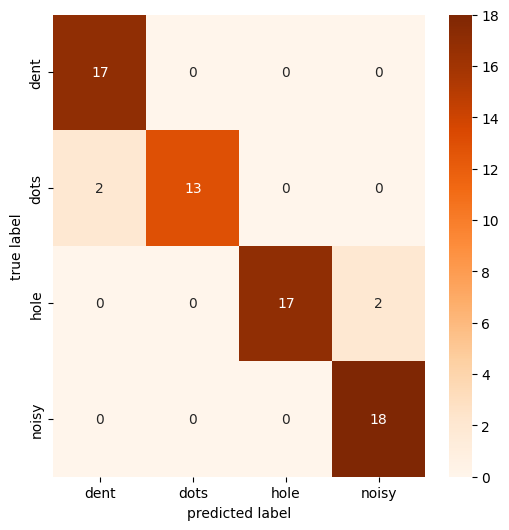

In [15]:
metrics_calculation(model = model_alexnet, dataloader = 'valid')

Довольно высокие показатели по всем метрикам. F1-мера > 0.91 для всех категорий дефектов.

По матрице ошибок видим, что модель в 2 случаях предсказала `Dent` вместо `Dots` и `Noisy` вместо `Hole` .

Metrics for test set


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


              precision    recall  f1-score   support

        dent       0.67      1.00      0.80         8
        dots       1.00      0.86      0.92         7
        hole       0.89      0.89      0.89         9
       noisy       0.83      0.56      0.67         9

    accuracy                           0.82        33
   macro avg       0.85      0.83      0.82        33
weighted avg       0.84      0.82      0.81        33



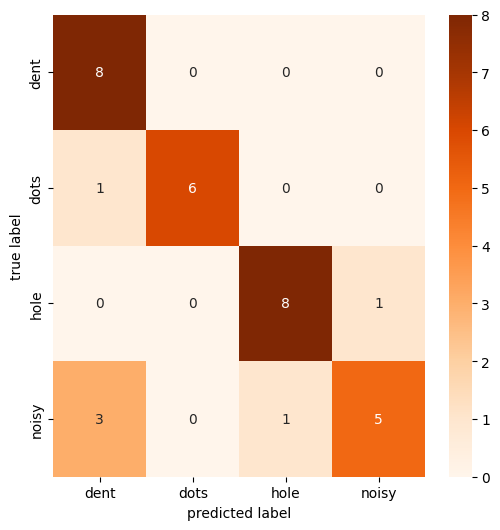

In [17]:
metrics_calculation(model = model_alexnet, dataloader = 'test')

На тестовой выборке результаты оказались чуть похуже. Видим, что модель очень склонна к ложноположительным предсказаниям для типа `Dent` (как следствие низкий precision у Dent). Также модель довольно часто пропускает класс `Noisy`, вместо него предсказала `Dent` и `Hole`(как следствие низкий recall у Dent).


Тем не менее, F1-мера для `Dots` и `Hole` >= 0.89. А общая точность составляет 0.82.

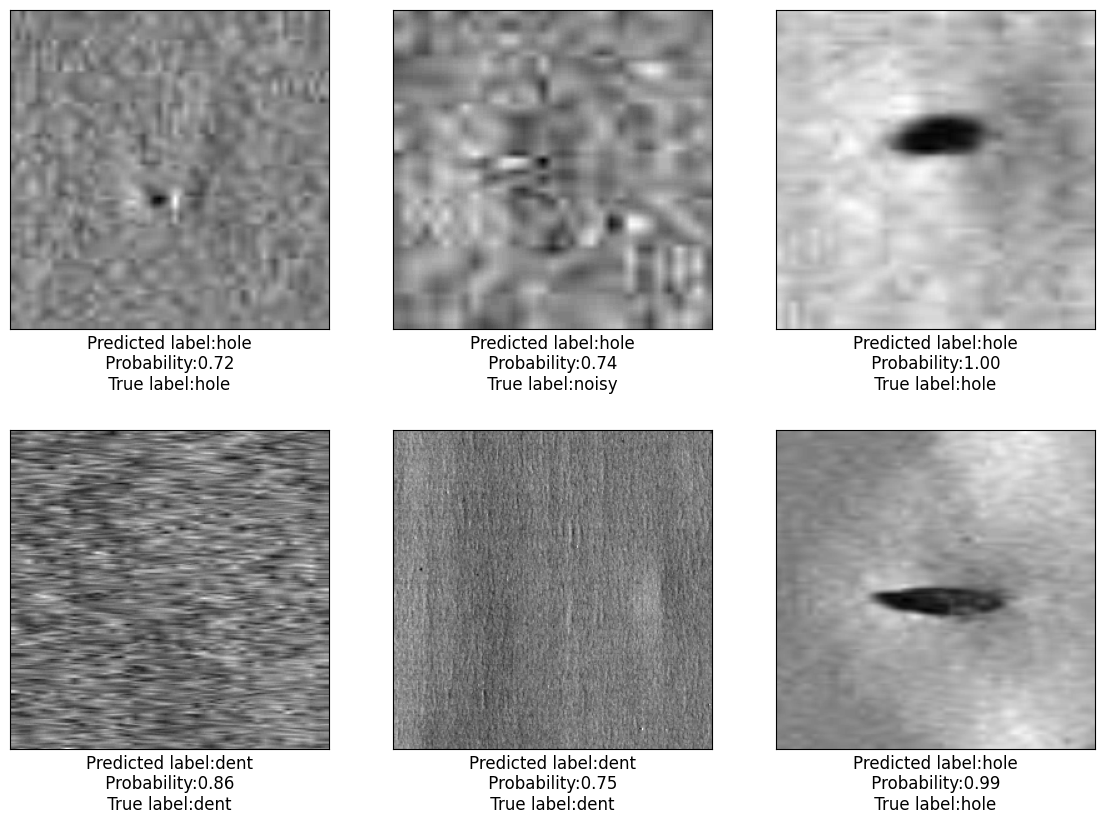

In [ ]:
visualize_model(model_alexnet, dataloader='test' )

In [ ]:
def predict_single_image(model, test_image_path):
  transform = data_transforms['test']
  test_image = Image.open(test_image_path)

  plt.imshow(test_image)

  test_image_tensor = transform(test_image)

  if torch.cuda.is_available():
    test_image_tensor = test_image_tensor.view(1,3,256,256).cuda()
  else:
    test_image_tensor = test_image_tensor.view(1,3,256,256)

  with torch.no_grad():
    model.eval()

    output = model(test_image_tensor)
    _, pred = torch.max(output, 1)
    pred_prob = torch.softmax(output, 1)

    print(f'Predicted label:{class_names[pred]}\nPredicted probability: {pred_prob.max() :.2f}')


Predicted label:dots
Predicted probability: 0.94


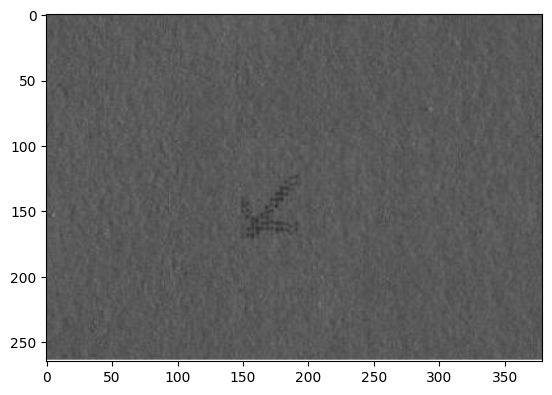

In [ ]:
predict_single_image(model = model_alexnet, test_image_path = '/content/steel_surface_defects/test/dots/dots_40_jpg.rf.7443e17e11bb440f9a56bc58bbd665a0.jpg')


# Загружаем модель для инференса

In [ ]:
inf_model = models.alexnet()
inf_model.classifier = nn.Linear(9216, 4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_to_model = '/content/alexnet.pth'

inf_model.load_state_dict(torch.load(path_to_model, map_location=torch.device('cpu')) )

inf_model = inf_model.to(device)

inf_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=4, bias=True)
)

In [ ]:
mean =  torch.tensor([0.3512, 0.3512, 0.3512])
std = torch.tensor([0.0389, 0.0389, 0.0389])

data_transforms = {
    'test': transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
    }

Predicted label:hole
Predicted probability: 0.99


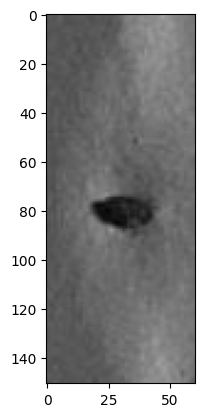

In [ ]:
inference_path = '/content/steel_surface_defects/test/hole/1618313342_jpg.rf.f6a23d1719df4debe471d0e8a76cfb98.jpg'

predict_single_image(inf_model, inference_path)


# Вывод

Был собран датасет из изображений дефектов на поверхности стали для обучения модели классификатора. Датасет содержит **331** изображение.  Данные были разделены на тренировочную, тестовую и валидационную выборки в соотношении **70 : 20 : 10**. В данных отсутствует дисбаланс по классам.

Из имеющихся снимков удалось выделить 4 типа дефектных структур: `Noise`, `Dent`, 'Hole', `Dots`. Их описание приводится в разделе визуализация.


В качестве бейзлайна была выбрана предобученная сеть **AlexNet**. По опыту использваония в задачах классфикации простых изображений в оттенках серого она показала себя лучше, чем более сложные сети.


В качестве оптимизатора использовался **SGD** c начальным **learning rate** равным **1e-03**.

Точность(accuracy) модели на валидационном наборе данных составила 0.94; на тестовом наборе данных - 0.82.

Модели **Resnet18**, **Vgg16**, **ConvNext_small** не смогли превзойти бейзлайн AlexNet.

При более внимательном анализе предсказаний модели на тестовой выборке было обнаружено, что модель склонно к ложноположительным предсказаниями для класса `Dent` и ложноотрицательным предсказаниям для класса `Noise`. У классов `Dots` и `Hole` довольно высокие показатели по всем метрикам.

В дальнейшем необходимо лучше понять природу и причину самих дефектов для более осознанного разделений изображений на классы, а также генерации синтетических изображений.


# Дополнительно

## попытка обучить ResNet

In [19]:
model_resnet18 = models.resnet18(pretrained=True)  #  for ResNET 18

# for param in model_resnet18.parameters():
#     param.requires_grad = False

num_ftrs = model_resnet18.fc.in_features   #  for ResNET

model_resnet18.fc = nn.Linear(num_ftrs, 4)

In [20]:
model_resnet18 = model_resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(model_resnet18.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

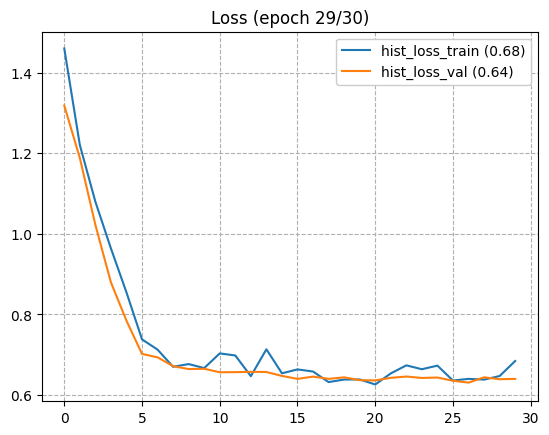

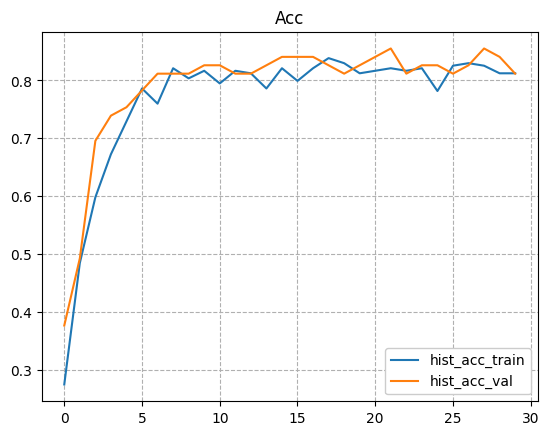

Best validation accuracy:0.855
Best validation loss:0.64
Best validation epoch:21


In [21]:
model_resnet18,best_acc_resnet = train_model(model_resnet18, criterion, optimizer_resnet, exp_lr_scheduler, 30)


In [28]:
torch.save(model_resnet18.state_dict(), 'resnet18.pth')